In [322]:
import pandas as pd
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from seaborn import clustermap
from matplotlib import pyplot as plt
import seaborn as sns 
import re
import numpy as np
import scipy

sns.set()

Notebook content:
<ul>
    <li>Scaling predictions between 0 - 1</li>
    <li>Plotting prediction scores for all tools</li>
    <li>Precision recall plots</li>
    <li>Comparing performance in different genomic regions</li>
    <li>Comparing performance for different allele frequencies</li>
    <li>Balancing the data for ROC AUC comparison</li>
    <li>Score correlations</li>
</ul>

In [334]:
data = pd.read_csv('../data/data_nc.nctools-predictions.txt', sep='\t')

In [335]:
cols_scores = [x for x in data.columns if re.search(r'NCBoost_Score|NCBoost_precomputed_score|NCBoost_precomputed_chr|DeepSEA|ReMM|Eigen|LINSIGHT', x)]
cols_scores

['ReMM_score',
 'NCBoost_Score',
 'NCBoost_Score-merged-chrom-pos',
 'NCBoost_precomputed_score',
 'NCBoost_precomputed_chr_rank_perc',
 'NCBoost_precomputed_score-merged-chrom-pos',
 'NCBoost_precomputed_chr_rank_perc-merged-chrom-pos',
 'DeepSEA_Functional_significance_score',
 'Eigen_raw',
 'Eigen-phred',
 'Eigen PC_raw',
 'Eigen PC-phred',
 'Eigen_raw-merged-chr-pos',
 'Eigen PC_raw-merged-chr-pos',
 'LINSIGHT_score']

In [336]:
data[['#Chrom', 'Pos', 'label'] + cols_scores].head(20)

,#Chrom,Pos,label,ReMM_score,NCBoost_Score,NCBoost_Score-merged-chrom-pos,NCBoost_precomputed_score,NCBoost_precomputed_chr_rank_perc,NCBoost_precomputed_score-merged-chrom-pos,NCBoost_precomputed_chr_rank_perc-merged-chrom-pos,DeepSEA_Functional_significance_score,Eigen_raw,Eigen-phred,Eigen PC_raw,Eigen PC-phred,Eigen_raw-merged-chr-pos,Eigen PC_raw-merged-chr-pos,LINSIGHT_score
0,1,21835920,Pathogenic,0.925,0.043725,0.043725,NaN,NaN,NaN,NaN,0.052103,1.238354,16.94820,4.016659,22.9740,1.238354,4.016659,0.113951
1,1,55505180,Pathogenic,0.611,0.271459,0.271459,NaN,NaN,NaN,NaN,0.066242,0.659571,12.95600,4.729346,25.1265,0.659571,4.729346,0.214607
2,1,113498814,Pathogenic,0.987,0.286262,0.286262,NaN,NaN,NaN,NaN,0.002187,2.062309,29.96190,6.894449,34.0382,2.062309,6.894449,0.055969
3,1,209975332,Pathogenic,0.931,0.233192,0.233192,NaN,NaN,NaN,NaN,0.019955,1.407326,18.67910,1.703142,16.7387,1.407326,1.703142,0.160774
4,1,209975361,Pathogenic,0.692,0.081881,0.081881,NaN,NaN,NaN,NaN,0.033797,0.769803,13.72960,1.578439,16.3985,0.769803,1.578439,0.081169
5,1,209979367,Pathogenic,0.921,0.161182,0.161182,NaN,NaN,NaN,NaN,0.006112,1.468657,19.47700,4.528953,24.4949,1.468657,4.528953,0.061968
6,1,209979435,Pathogenic,0.959,0.189841,0.189841,NaN,NaN,NaN,NaN,0.002021,1.475929,19.57810,4.260180,23.6961,1.475929,4.260180,0.274090
7,1,216596610,Pathogenic,0.913,0.257114,0.257114,NaN,NaN,NaN,NaN,0.010616,0.849738,14.25140,-0.038676,7.9590,0.849738,-0.038676,0.219858
8,1,228337561,Pathogenic,0.997,0.467702,0.467702,0.427995,0.977008,0.427995,0.977008,0.015348,1.784597,25.38060,3.232283,20.8083,1.784597,3.232283,0.671686
9,10,27389371,Pathogenic,0.986,0.162982,0.162982,NaN,NaN,NaN,NaN,0.007389,1.493691,4.85036,5.282147,27.0885,1.493691,5.282147,0.078774


In [339]:
data_hc = data[(data.NCBoost_data == True) | (data.sample_weight == 1)]

print('Data info')
print(data.shape)
print(data.label.value_counts())

print('\nHigh-confidence variants')
print(data_hc.shape)
print(data_hc.label.value_counts())

Data info
(82188, 177)
Benign        79577
Pathogenic     2611
Name: label, dtype: int64

High-confidence variants
(7308, 177)
Benign        5956
Pathogenic    1352
Name: label, dtype: int64


<h3>Scaling predictions between 0 - 1</h3>

To easily compare predictions with each other, scale all of them between 0 and 1. 

In [340]:
#Max values
data[cols_scores].max()

ReMM_score                                             1.000000
NCBoost_Score                                          0.918831
NCBoost_Score-merged-chrom-pos                         0.918831
NCBoost_precomputed_score                              0.953254
NCBoost_precomputed_chr_rank_perc                      0.999986
NCBoost_precomputed_score-merged-chrom-pos             0.953254
NCBoost_precomputed_chr_rank_perc-merged-chrom-pos     0.999986
DeepSEA_Functional_significance_score                  0.804400
Eigen_raw                                              3.834147
Eigen-phred                                           53.846400
Eigen PC_raw                                          10.676047
Eigen PC-phred                                        50.580700
Eigen_raw-merged-chr-pos                               3.834147
Eigen PC_raw-merged-chr-pos                           10.676047
LINSIGHT_score                                         0.993462
dtype: float64

In [341]:
#Min values
data[cols_scores].min()

ReMM_score                                            0.000000
NCBoost_Score                                         0.008056
NCBoost_Score-merged-chrom-pos                        0.008056
NCBoost_precomputed_score                             0.009636
NCBoost_precomputed_chr_rank_perc                     0.000161
NCBoost_precomputed_score-merged-chrom-pos            0.009636
NCBoost_precomputed_chr_rank_perc-merged-chrom-pos    0.000161
DeepSEA_Functional_significance_score                 0.000010
Eigen_raw                                            -1.507438
Eigen-phred                                           0.000049
Eigen PC_raw                                         -0.365435
Eigen PC-phred                                        0.000089
Eigen_raw-merged-chr-pos                             -1.507438
Eigen PC_raw-merged-chr-pos                          -0.365435
LINSIGHT_score                                        0.034344
dtype: float64

In [342]:
scale_min_max = lambda x: (data[x] - data[x].min()) / (data[x].max() - data[x].min())
for x in cols_scores:
    if 'DeepSEA' in x:
        #The DeepSEA functional significance is an e-value, so the lower the value, the more significant. 
        #Therefore convert values to value = 1 - value to easily compare it with the other tools.
        data[x] = data[x].apply(lambda x: 1-x)
    data[x + '-scaled'] = scale_min_max(x)

<h2>Plotting prediction scores for all tools</h2>

In [367]:
def plot_scores_for_tools(df, columns, title, width=16, height=8, rename_tools=False):
    print(df.shape)
    melted_df = pd.melt(df[columns + ['label']], id_vars='label', value_vars=columns)
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    plt.suptitle(title, fontsize=24, y=1.08)
    
    sns.violinplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", split=True, cut=0, ax=axes[0])
    sns.boxplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", showfliers=False, ax=axes[1])

    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='w', edgecolor='w')
    axes[1].get_legend().remove()
    
    for ax in axes:
        ax.set(xlabel='Score', ylabel='')

    plt.tight_layout()

def plot_scores_vertical_violinplot(df, columns, title, width=16, height=8, savefig=False):
    print(df.shape)
    melted_df = pd.melt(df[columns + ['label']], id_vars='label', value_vars=columns)
    melted_df['variable'] = melted_df.variable.apply(lambda x: x.split('_')[0])
    plt.figure(figsize=(width, height))
    print(title)
    sns.violinplot(x='variable', y="value", hue='label', data=melted_df, palette="muted", split=True, cut=0, orient='v')
    plt.xlabel('')
    plt.ylabel('Score')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='w', edgecolor='w')
    plt.tight_layout
    if savefig:
        plt.savefig('../figures/benchmark_analysis/' + title + '.png', bbox_inches = "tight")
        plt.savefig('../figures/benchmark_analysis/' + title + '.pdf', bbox_inches = "tight")
    

(82188, 192)


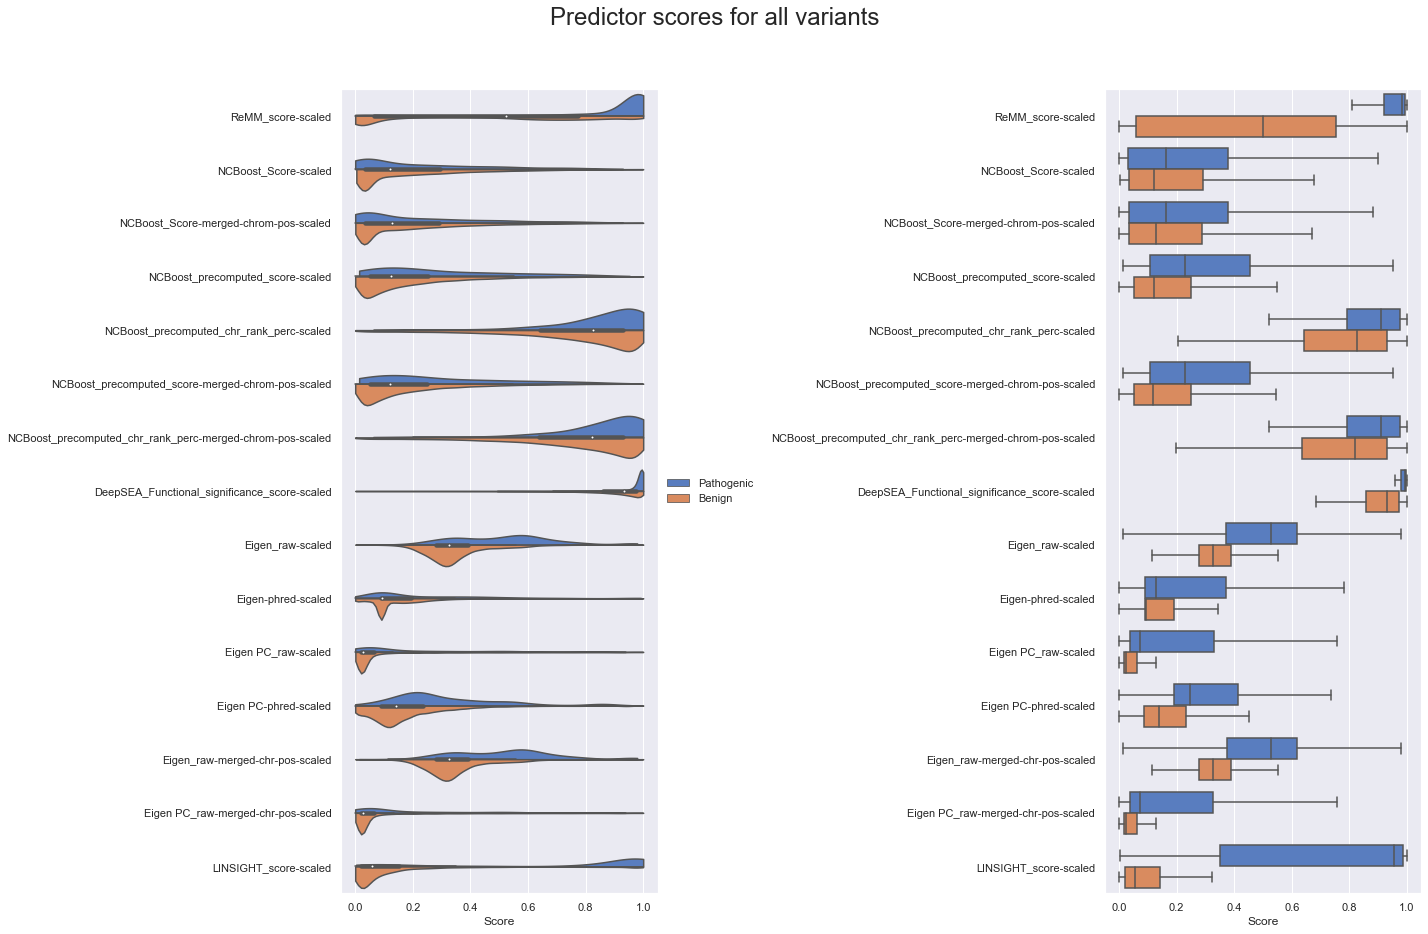

In [356]:
cols_scores_scaled = [x + '-scaled' for x in cols_scores]
plot_scores_for_tools(data, columns=cols_scores_scaled, width=20, height=12, title='Predictor scores for all variants')

The tools that seem to predict well are ReMM, DeepSEA, Eigen-raw and Linsight. The only tool that does not perform well is NCBoost. It's also weird that the precomputed NCBoost score seems to be better at discriminating than the NCBoost scores obtained by utilizing the tool. 

(7308, 192)


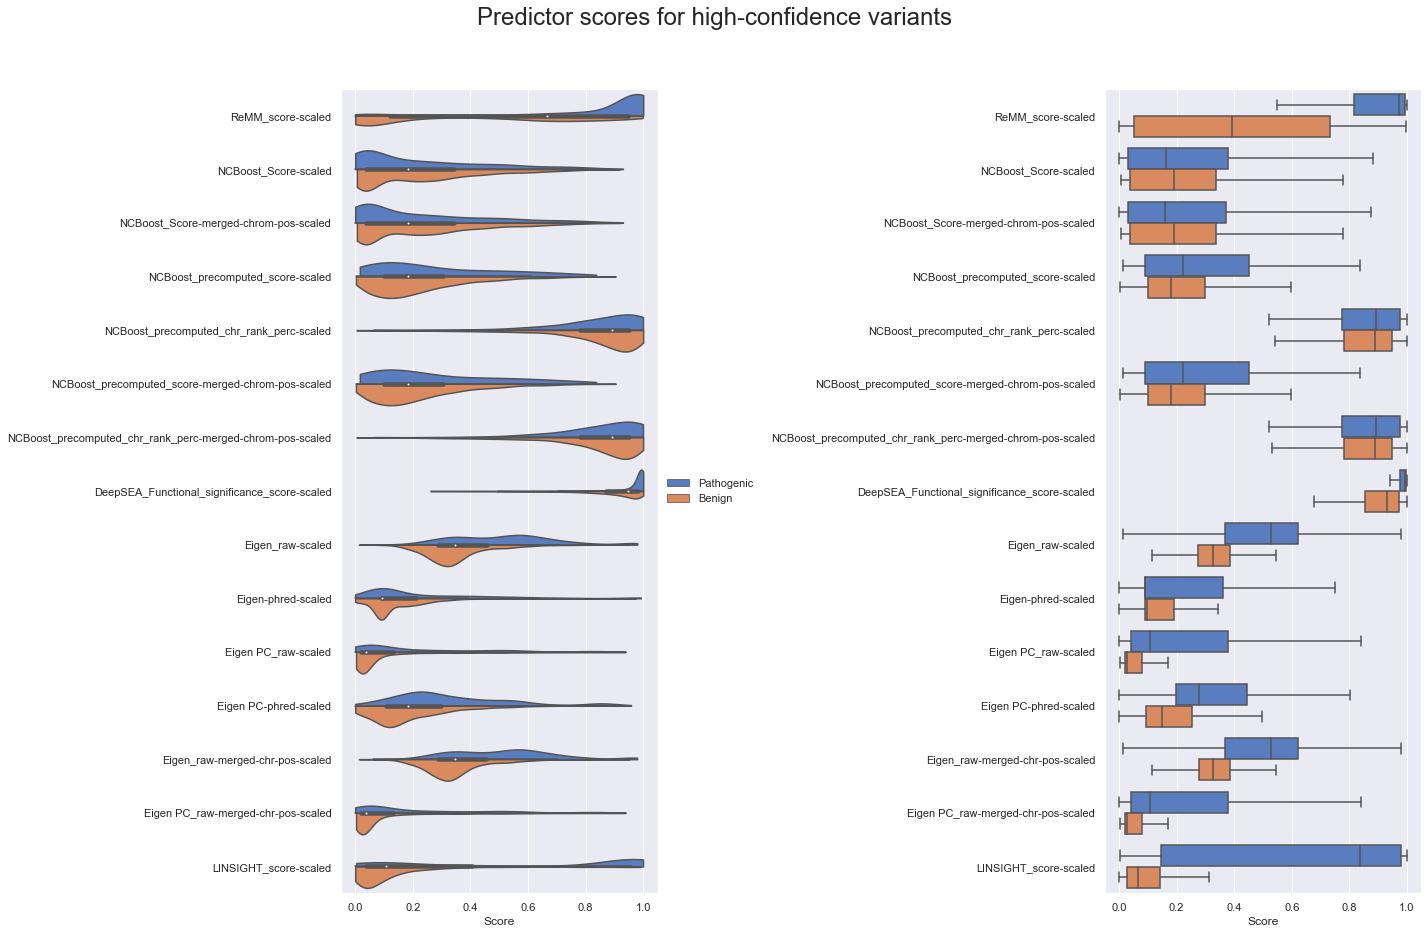

In [357]:
cols_scores_scaled = [x + '-scaled' for x in cols_scores]
data_hc = data[(data.NCBoost_data == True) | (data.sample_weight == 1)]

plot_scores_for_tools(data_hc, columns=cols_scores_scaled, width=20, height=12, title='Predictor scores for high-confidence variants')

NCBoost performs worse than random here. Also interesting to see that for Eigen the pathogenic variants seem to form two distributions since Eigen is an unsupervised approach. <b>TODO:</b> investigate why Eigen predicts low scores for the left distribution. How are these variants ranked by the other tools? 

<h3>Cleaned up plots</h3>

(82188, 192)
Predictor scores for all variants


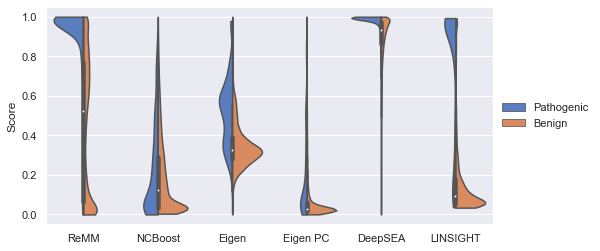

In [368]:
cols = [
    'ReMM_score-scaled',
    'NCBoost_Score-scaled',
    'Eigen_raw-scaled',
    'Eigen PC_raw-scaled',
    'DeepSEA_Functional_significance_score-scaled',
    'LINSIGHT_score'
]

plot_scores_vertical_violinplot(data, columns=cols, width=8, height=4, title='Predictor scores for all variants', savefig=True)


(7308, 192)
Predictor scores for high-confidence variants


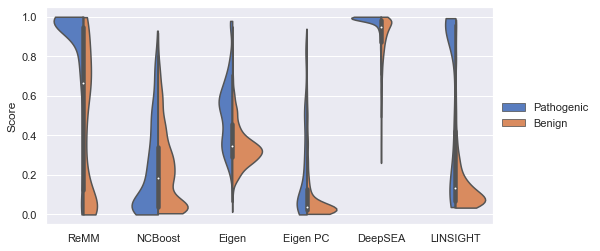

In [371]:
plot_scores_vertical_violinplot(data_hc, columns=cols, width=8, height=4, title='Predictor scores for high-confidence variants', savefig=True)

<h1>PR and ROC plots</h1>

Only variants that have predictions for all tools can be used for the PR plot. This decreases the number of pathogenic variants we can use. 

In [372]:
counts = lambda all_data, hc_data: pd.concat([all_data.label.value_counts().rename('All variants'), hc_data.label.value_counts().rename('High-confidence')], axis=1)

print('All data')
print(counts(data, data_hc))

print("\n\nSNV's")
print(counts(
    data[data.Ref.apply(lambda x: len(x) == 1) & data.Alt.apply(lambda x: len(x) == 1)],
    data_hc[data_hc.Ref.apply(lambda x: len(x) == 1) & data_hc.Alt.apply(lambda x: len(x) == 1)]
))

l = ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))

l.remove('NCBoost_Score')
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))
      

All data
            All variants  High-confidence
Benign             79577             5956
Pathogenic          2611             1352


SNV's
            All variants  High-confidence
Benign             69055             2273
Pathogenic          2369             1232


Variants that have predictions for the tools ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
            All variants  High-confidence
Benign             25594             1481
Pathogenic           484              439


Variants that have predictions for the tools ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
            All variants  High-confidence
Benign             62655             2051
Pathogenic           859              670


If we will use all tools, only 484 pathogenic variants remain of which 439 are high-confidence. If we exclude NCBoost, 859 pathogenic variants remain of which 670 are high confidence.

In [744]:
tool_colors = {
    'NCBoost': sns.color_palette('colorblind')[5], 
    'ReMM': sns.color_palette('colorblind')[4], 
    'DeepSEA': sns.color_palette('colorblind')[0], 
    'Eigen': sns.color_palette('colorblind')[1], 
    'Eigen PC': sns.color_palette('colorblind')[2],
    'LINSIGHT': sns.color_palette('colorblind')[3]
}

In [745]:
def plot_curve(df, cols, metric, title, auc_label='AUC'):
    values = []
    for tool in cols:
        if metric == 'pr':
            p, r, t = precision_recall_curve(df.binarized_label, df[tool])
            values.append([tool, p, r, round(average_precision_score(df.binarized_label, df[tool]), 3)])
        elif metric == 'roc':
            fpr, tpr, thresholds = roc_curve(df.binarized_label, df[tool])
            values.append([tool, tpr, fpr, round(auc(fpr, tpr), 3)])

    plt.figure(figsize=(9, 5))
    values = sorted(values, key=lambda x: x[3])[::-1]
    
    for tool in values:
        plt.plot(
            tool[2],
            tool[1], 
            color=tool_colors[re.split(r'-|_', tool[0])[0]],
            label='{} ({}: {})'.format(
                re.split(r'-|_', tool[0])[0], 
                auc_label,
                tool[3], 
            )
        )
    if metric == 'pr':
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    elif metric == 'roc':
        plt.xlabel('1 - Specificity (FPR)')
        plt.ylabel('Sensitivity (TPR)')
    
    plt.legend()
    plt.savefig('../figures/benchmark_analysis/curves/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/curves/' + title + '.pdf', bbox_inches = "tight")
        

Precision recall plot for the variants for which we could retrieve predictions from all tools. 

Benign        25594
Pathogenic      484
Name: label, dtype: int64


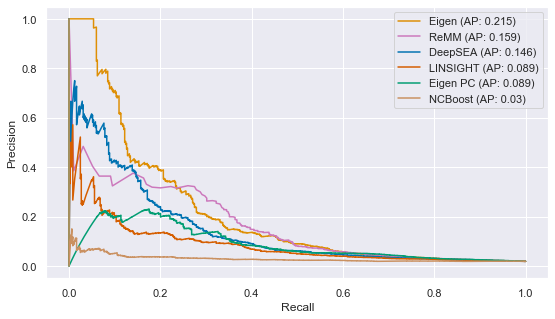

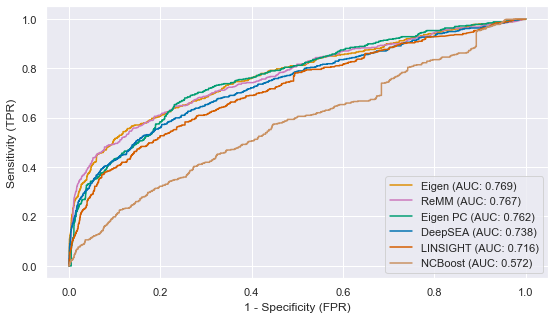

In [746]:
cols = ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw-scaled', 'Eigen PC_raw', 'LINSIGHT_score-scaled']
data_filtered = data.dropna(subset=cols)
print(data_filtered.label.value_counts())
p = data_filtered.label.value_counts()['Pathogenic']
b = data_filtered.label.value_counts()['Benign']
plot_curve(metric='pr', df=data_filtered, cols=cols, auc_label='AP', title='All-variants_Benign-' + str(b) + '_Pathogenic-' + str(p) + '_PR')
plot_curve(metric='roc', df=data_filtered, cols=cols, title='All-variants_Benign-' + str(b) + '_Pathogenic-' + str(p) + '_ROC')



For these 484 pathogenic variants and 25594 benign variants, Eigen performs best, followed by ReMM, DeepSEA, LiNSIGHT and lastly NCBoost. If NCBoost is left out, much more pathogenic variants remain in the data. Therefore also plot without NCBoost:

Benign        62655
Pathogenic      859
Name: label, dtype: int64


//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


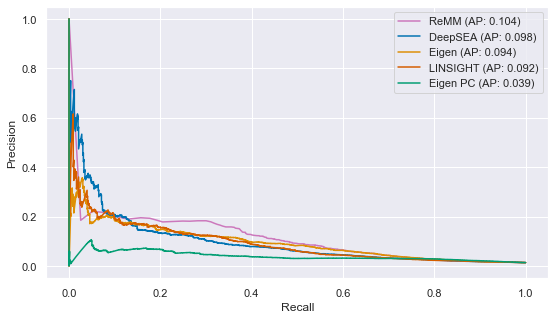

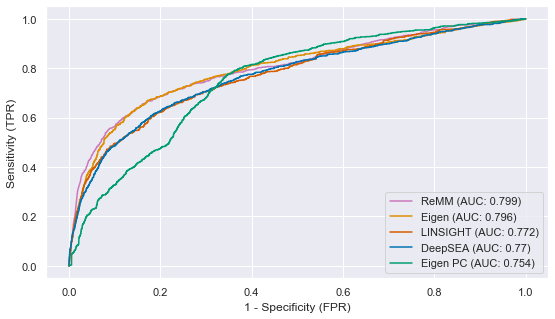

In [747]:
cols = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=cols)
print(data_filtered.label.value_counts())

plot_curve(metric='pr', df=data_filtered, cols=cols, auc_label='AP', title='All-variants_Benign-' + str(data_filtered.label.value_counts()['Benign']) + '_Pathogenic-' + str(data_filtered.label.value_counts()['Pathogenic']) + '_PR')
plot_curve(metric='roc', df=data_filtered, cols=cols, title='All-variants_Benign-' + str(data_filtered.label.value_counts()['Benign']) + '_Pathogenic-' + str(data_filtered.label.value_counts()['Pathogenic']) + '_ROC')


Now, ReMM is best, followed by DeepSEA, Eigen and lastly LiNSIGHT. The plot is difficult to read because of the high number of benign variants. Also plot with high confidence SNPs only. This also might make the plot easier to read as the number of benign variants will be lowered a lot.

Benign        2051
Pathogenic     670
Name: label, dtype: int64


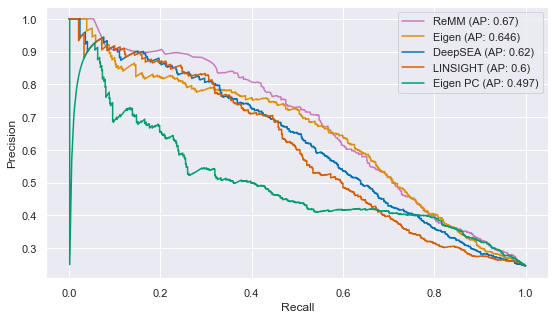

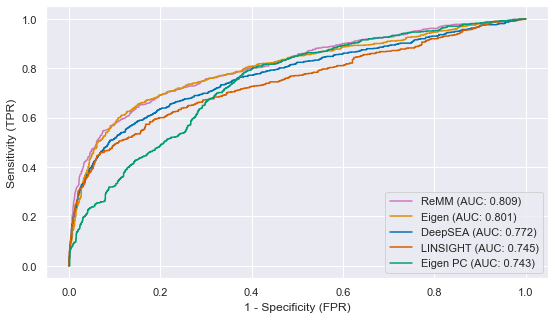

In [748]:
cols = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=cols)
data_filtered = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered.label.value_counts())

p = data_filtered.label.value_counts()['Pathogenic']
b = data_filtered.label.value_counts()['Benign']
plot_curve(metric='pr', df=data_filtered, cols=cols, auc_label='AP', title='HC-variants_Benign-' + str(b) + '_Pathogenic-' + str(p) + '_PR')
plot_curve(metric='roc', df=data_filtered, cols=cols, title='HC-variants_Benign-' + str(b) + '_Pathogenic-' + str(p) + '_ROC')


Also plot high confidence SNPs with NCBoost included:

Benign        1481
Pathogenic     439
Name: label, dtype: int64


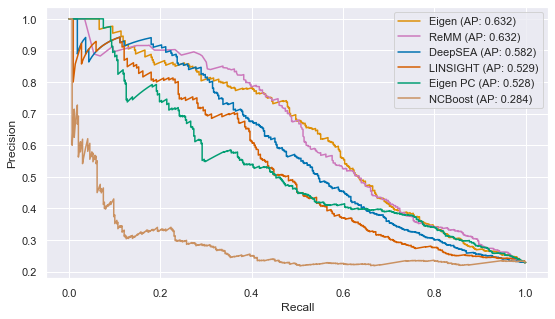

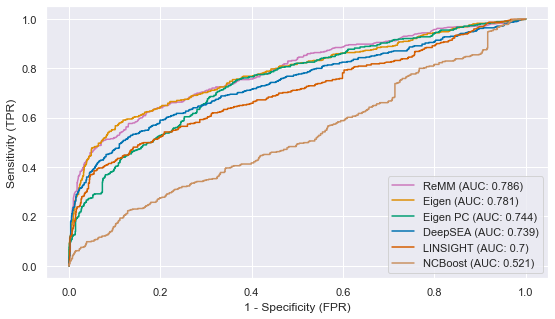

In [749]:
cols = ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score']
data_filtered = data.dropna(subset=cols)
data_filtered = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered.label.value_counts())

p = data_filtered.label.value_counts()['Pathogenic']
b = data_filtered.label.value_counts()['Benign']
plot_curve(metric='pr', df=data_filtered, cols=cols, auc_label='AP', title='HC-variants_Benign-' + str(b) + '_Pathogenic-' + str(p) + '_PR')
plot_curve(metric='roc', df=data_filtered, cols=cols, title='HC-variants_Benign-' + str(b) + '_Pathogenic-' + str(p) + '_ROC')


<h1>Comparing performance in different genomic regions</h1>

Do comparisons both for all data and high confidence data. Leave NCBoost out because half of the pathogenic variants don't have an NCBoost score and it doesn't perform well anyway. 

In [445]:
tools = sorted(['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])

<h3>Number of variants per region</h3>

In [670]:
print('Numbers for all variants that have predictions for all tools')
counts_regions = lambda pathogenic_data, benign_data: pd.concat([pathogenic_data.Consequence.value_counts().rename('Pathogenic'), benign_data.Consequence.value_counts().rename('Benign')], axis=1, sort=False)
data_filtered = data.dropna(subset=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])
print(data_filtered.label.value_counts())
counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign'])


Numbers for all variants that have predictions for all tools
Benign        62655
Pathogenic      859
Name: label, dtype: int64


,Pathogenic,Benign
INTRONIC,239.0,34755.0
UPSTREAM,238.0,6729.0
5PRIME_UTR,196.0,1062.0
DOWNSTREAM,103.0,11896.0
3PRIME_UTR,59.0,7227.0
NONCODING_CHANGE,21.0,980.0
SPLICE_SITE,3.0,NaN
INTERGENIC,NaN,6.0


In [671]:
print('Numbers for high-confidence variants that have predictions for all tools')
data_filtered_hc = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered_hc.label.value_counts())
counts_regions(data_filtered_hc[data_filtered_hc.label == 'Pathogenic'], data_filtered_hc[data_filtered_hc.label == 'Benign'])


Numbers for high-confidence variants that have predictions for all tools
Benign        2051
Pathogenic     670
Name: label, dtype: int64


,Pathogenic,Benign
5PRIME_UTR,196,124.0
UPSTREAM,186,57.0
INTRONIC,181,1690.0
3PRIME_UTR,57,89.0
DOWNSTREAM,41,80.0
NONCODING_CHANGE,6,11.0
SPLICE_SITE,3,NaN


<h3>Score plots per region</h3>

In [672]:
#Only use these regions as the others don't have enough variants
regions = sorted(['INTRONIC', 'UPSTREAM', 'DOWNSTREAM', '5PRIME_UTR', '3PRIME_UTR'])

In [691]:

def plot_scores_per_category_per_tool(df, col, title, nrows, ncols, figsize=(12, 8), legend_pos=1):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    plt.suptitle(title, fontsize=18, y=1.05)
    for i in range(len(tools)):
        tool = tools[i]
        name = re.split(r'-|_', tool)[0]
        ax0 = axes[i]
        regions = list(set(df[col]))
        sns.boxplot(
            x=tool,
            y=col,
            hue='label',
            data=df,
            palette='muted',
            showfliers=False,
            order=sorted(list(set(df[col]))),
            ax=ax0
        )
        ax0.set_title(name)  
        ax0.set(xlabel='Score', ylabel='')
        ax0.get_legend().remove()
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(legend_pos, 0.5), facecolor='w', edgecolor='w')  #bbox_to_anchor  (width, height)
    plt.tight_layout()
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.pdf', bbox_inches = "tight")

def plot_ap_per_tool_per_category(df, col, tools, categories, rows, cols, title, figsize=(12,6)):

    df_filtered = df[df[col].isin(categories)]
    tool_names = sorted([re.split(r'-|_', tool)[0] for tool in tools])[::-1]
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.suptitle(title, fontsize=16, y=1.05)
    axes = axes.flatten()
    
    for i in range(len(categories)):
        category = categories[i]
        ax = axes[i]
        df_filtered_category = df[df[col] == category]
        aps = [average_precision_score(df_filtered_category.binarized_label, df_filtered_category[tool]) for tool in tools]
        ax.barh(y=tool_names, width=aps)
        ax.set(xlabel='Average precision')
        ax.set_title(category)     
    
    plt.tight_layout()
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.png', bbox_inches = "tight")
    plt.savefig('../figures/benchmark_analysis/genomic_regions_and_af_bins/' + title + '.pdf', bbox_inches = "tight")

Benign        62655
Pathogenic      859
Name: label, dtype: int64
                  Pathogenic   Benign
INTRONIC               239.0  34755.0
UPSTREAM               238.0   6729.0
5PRIME_UTR             196.0   1062.0
DOWNSTREAM             103.0  11896.0
3PRIME_UTR              59.0   7227.0
NONCODING_CHANGE        21.0    980.0
SPLICE_SITE              3.0      NaN
INTERGENIC               NaN      6.0


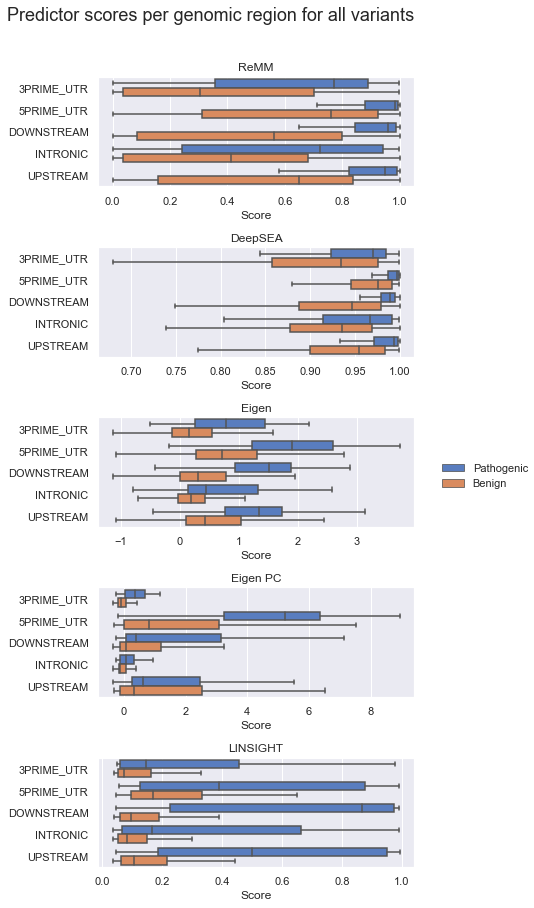

In [692]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    col='Consequence', 
    title='Predictor scores per genomic region for all variants', 
    nrows=5, ncols=1, figsize=(6,12))


Benign        2051
Pathogenic     670
Name: label, dtype: int64
                  Pathogenic  Benign
5PRIME_UTR               196   124.0
UPSTREAM                 186    57.0
INTRONIC                 181  1690.0
3PRIME_UTR                57    89.0
DOWNSTREAM                41    80.0
NONCODING_CHANGE           6    11.0
SPLICE_SITE                3     NaN


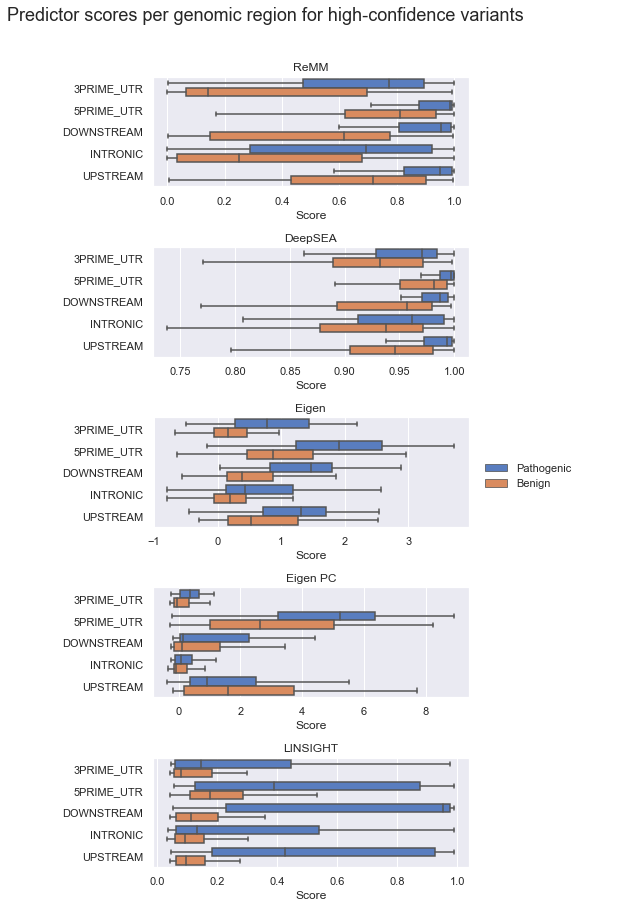

In [693]:
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    col='Consequence', 
    title='Predictor scores per genomic region for high-confidence variants', 
    nrows=5, ncols=1, figsize=(6,12), legend_pos=1.1)


<h3>Average precision per tool for all regions</h3>

Benign        62655
Pathogenic      859
Name: label, dtype: int64
                  Pathogenic   Benign
INTRONIC               239.0  34755.0
UPSTREAM               238.0   6729.0
5PRIME_UTR             196.0   1062.0
DOWNSTREAM             103.0  11896.0
3PRIME_UTR              59.0   7227.0
NONCODING_CHANGE        21.0    980.0
SPLICE_SITE              3.0      NaN
INTERGENIC               NaN      6.0


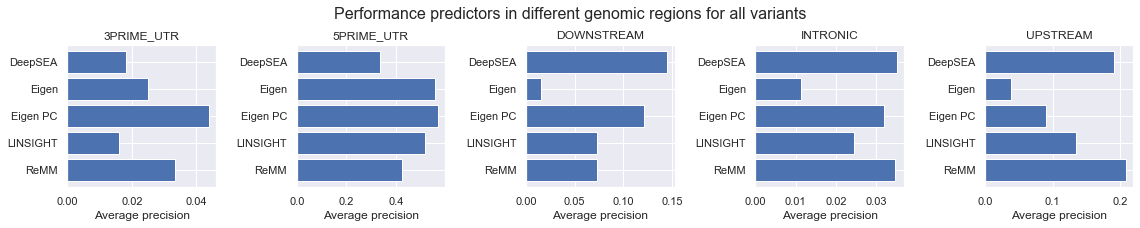

In [694]:
#Numbers for high confidence variants
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=regions, col='Consequence', tools=tools, rows=1, cols=5, figsize=(16,3), title='Performance predictors in different genomic regions for all variants') 


Because this is average precision, we can only compare the rankings of tools between regions with each other since AP is dependent on class ratio and different regions have different class ratios. 

Observations:
<ul>
    <li>LINSIGHT performs best in intronic, upstream and downstream, but worst of all tools in 5'utr and 3'utr (why could that be?).</li>
    <li>Eigen PC performs worst for intronic, upstream and downstream, good in 5'utr and average in 3'utr. </li>
    <li>Eigen performs best in 5'utr, 3'utr and intronic. Also performs good for downstream. Bad in upstream.</li>
    <li>ReMM performs best in intronic and upstream, and also good for 3'utr.</li>
    <li>DeepSEA worst in 3'utr.</li>
</ul>


Benign        2051
Pathogenic     670
Name: label, dtype: int64
                  Pathogenic  Benign
5PRIME_UTR               196   124.0
UPSTREAM                 186    57.0
INTRONIC                 181  1690.0
3PRIME_UTR                57    89.0
DOWNSTREAM                41    80.0
NONCODING_CHANGE           6    11.0
SPLICE_SITE                3     NaN


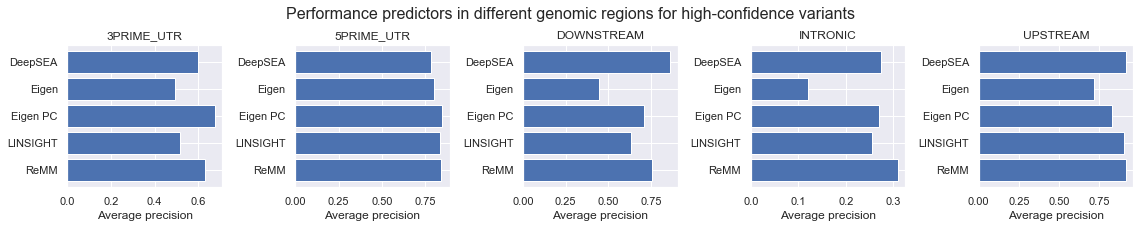

In [695]:
#Numbers for high confidence variants
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered.label.value_counts())
print(counts_regions(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=regions, col='Consequence', tools=tools, rows=1, cols=5, figsize=(16,3), title='Performance predictors in different genomic regions for high-confidence variants') 


Just as in the plot above, Eigen PC performs worst for intronic, downstream and upstream.
LInsight and ReMM best for instronic, upstream and downstream. 
Eigen best for 5'utr and 3'utr.

<h1>Comparing performance for different allele frequencies</h1>

In [697]:
# data_filtered = data.dropna(subset=tools)
bins = pd.cut(data.max_AF, [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1], include_lowest=True, right=False)
counts_af = lambda pathogenic_data, benign_data: pd.concat([pathogenic_data.bins.value_counts().rename('Pathogenic'), benign_data.bins.value_counts().rename('Benign')], axis=1, sort=False)
bins = bins.apply(lambda x: str(x).replace('[', '').replace(')', '').replace(',', ' -'))
data['bins'] = bins

data_filtered = data.dropna(subset=tools)
counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign'])


,Pathogenic,Benign
0.0 - 1e-06,186,7234
1e-06 - 1e-05,14,6120
1e-05 - 0.0001,47,15609
0.0001 - 0.001,61,8492
0.001 - 0.01,23,6140
0.01 - 1.0,9,18694


In [698]:
#TODO: add AF to NCBoost variants.
print(data.shape)
print(data_filtered.shape)
print(data_filtered.max_AF.isna().sum())
print(data_filtered[data_filtered.label == 'Pathogenic'].shape)
print(data_filtered[data_filtered.label == 'Pathogenic'].max_AF.isna().sum())

(82188, 193)
(63514, 193)
519
(859, 193)
519


<h3>Score plots for different AF bins<h3>

Benign        62655
Pathogenic      859
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06            186    7234
1e-06 - 1e-05           14    6120
1e-05 - 0.0001          47   15609
0.0001 - 0.001          61    8492
0.001 - 0.01            23    6140
0.01 - 1.0               9   18694


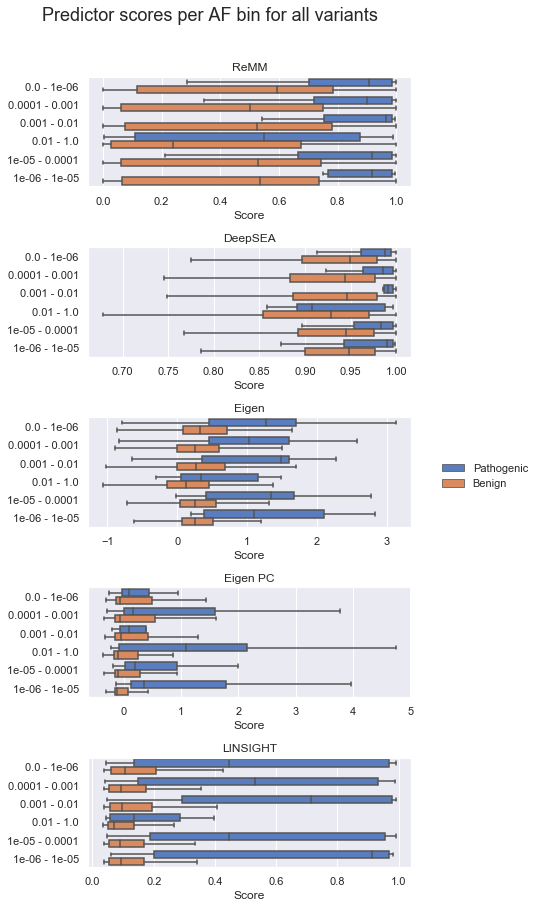

In [699]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered.dropna(subset=['bins']), 
    col='bins', 
    title='Predictor scores per AF bin for all variants', 
    nrows=5, ncols=1, figsize=(6,12))

Benign        2051
Pathogenic     670
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06             66      59
1e-06 - 1e-05            7      25
1e-05 - 0.0001          21     104
0.0001 - 0.001          34      93
0.001 - 0.01            18     255
0.01 - 1.0               5    1480


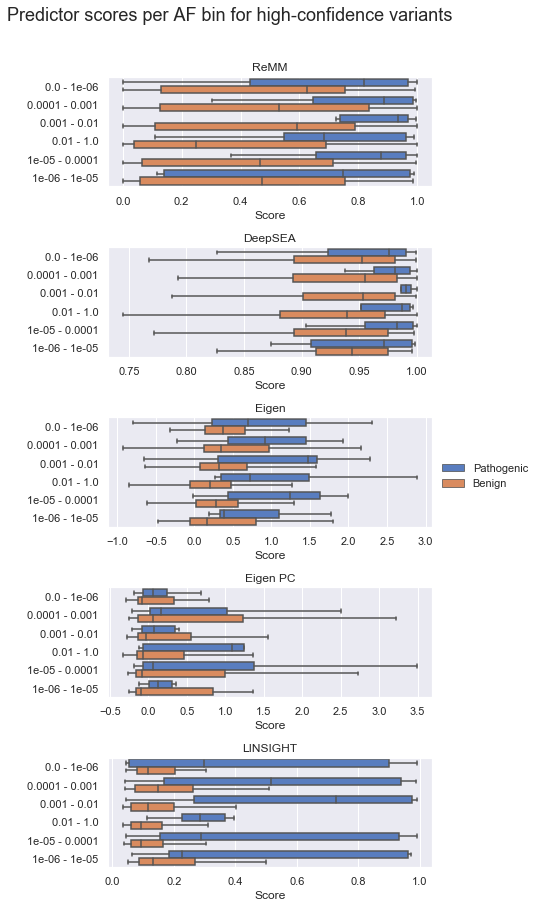

In [700]:
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_scores_per_category_per_tool(
    data_filtered.dropna(subset=['bins']), 
    col='bins', 
    title='Predictor scores per AF bin for high-confidence variants', 
    nrows=5, ncols=1, figsize=(6,12))

<h3>Average precision per tool for all AF bins</h3>

Benign        62655
Pathogenic      859
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06            186    7234
1e-06 - 1e-05           14    6120
1e-05 - 0.0001          47   15609
0.0001 - 0.001          61    8492
0.001 - 0.01            23    6140
0.01 - 1.0               9   18694


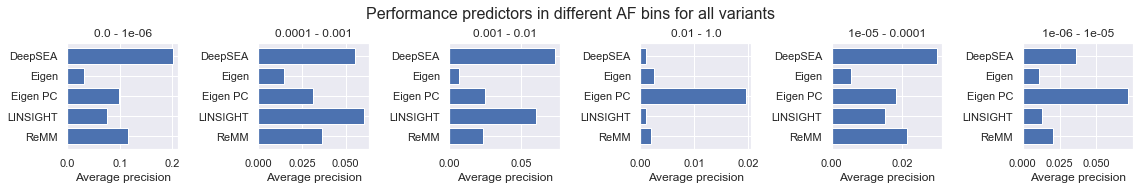

In [703]:
data_filtered = data.dropna(subset=tools)
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=sorted(list(set(bins.dropna()))), col='bins', tools=tools, rows=1, cols=len(list(set(bins.dropna()))), figsize=(16,2.5), title='Performance predictors in different AF bins for all variants') 


Benign        2051
Pathogenic     670
Name: label, dtype: int64
                Pathogenic  Benign
0.0 - 1e-06             66      59
1e-06 - 1e-05            7      25
1e-05 - 0.0001          21     104
0.0001 - 0.001          34      93
0.001 - 0.01            18     255
0.01 - 1.0               5    1480


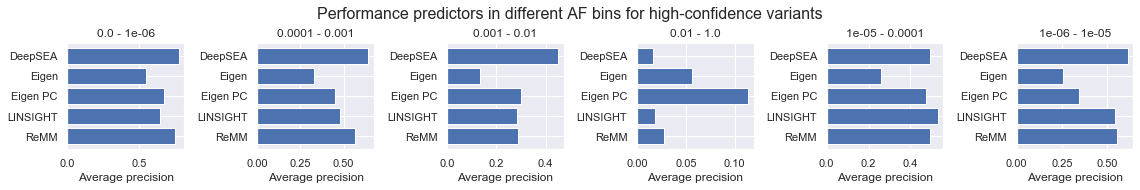

In [704]:
data_filtered = data.dropna(subset=tools)
data_filtered = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered.label.value_counts())
print(counts_af(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign']))
plot_ap_per_tool_per_category(data_filtered, categories=sorted(list(set(bins.dropna()))), col='bins', tools=tools, rows=1, cols=len(list(set(bins.dropna()))), figsize=(16,2.5), title='Performance predictors in different AF bins for high-confidence variants') 


<h1>Balancing the data for ROC AUC comparison</h1>

It's difficult to compare performance in different AF's and genomic regions because average precision is dependent on the class ratios. Therefore, do the same analyses as above but with balanced data.

In [705]:
tools = sorted(['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen_raw', 'Eigen PC_raw', 'LINSIGHT_score'])
regions = sorted(['INTRONIC', 'UPSTREAM', 'DOWNSTREAM', '5PRIME_UTR', '3PRIME_UTR'])
data_filtered = data.dropna(subset=tools)
data_filtered_hc = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]

In [706]:
def return_balanced_data(df, column, random_state):
    groups_regions = df.groupby(column, group_keys=False)
    balanced_dfs = []
    for name, df in groups_regions:
        labels = df.groupby('label', group_keys=False)
        balanced = labels.apply(lambda x: x.sample(labels.size().min(), random_state=random_state))
        balanced_dfs.append(balanced)
    balanced_df = pd.concat(balanced_dfs, axis=0)
    return balanced_df

def compute_roc_auc_values_per_tool_and_category(df, cols, categories):
    #For every tool/category combination, balances the dataframe 100 times using
    #100 different random states, and calculates the ROC AUC for each of them. 
    #Returns a dataframe with columns 'Tool', 'Category' and 'AUC' (100 rows
    #per tool/category combination). 

    print(df[df.label == 'Pathogenic'][categories].value_counts())
    
    all_auc_values = []
    for n, category in enumerate(list(set(df[categories]))):
        for i in range(100):
            df_f = df[df[categories] == category]
            g = df_f.groupby('label', group_keys=False)
            balanced = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(), random_state=i)))
            for tool in cols:
                fpr, tpr, t = roc_curve(balanced.binarized_label, balanced[tool], pos_label=1)
                all_auc_values.append([tool.split('_')[0], category, round(auc(fpr, tpr), 3)])
                
    auc_values_df = pd.DataFrame(all_auc_values, columns=['Tool', 'Category', 'ROC AUC'])
    
    return auc_values_df


<h3>Genomic regions</h3>

In [707]:
balanced_regions = return_balanced_data(data_filtered[data_filtered.Consequence.isin(regions)], column='Consequence', random_state=53)
print('All variants')
counts_regions(balanced_regions[balanced_regions.label == 'Pathogenic'], balanced_regions[balanced_regions.label == 'Benign'])

All variants


,Pathogenic,Benign
INTRONIC,239,239
UPSTREAM,238,238
5PRIME_UTR,196,196
DOWNSTREAM,103,103
3PRIME_UTR,59,59


In [708]:
balanced_regions_hc = return_balanced_data(data_filtered_hc[data_filtered_hc.Consequence.isin(regions)], column='Consequence', random_state=53)
print('High-confidence variants')
counts_regions(balanced_regions_hc[balanced_regions_hc.label == 'Pathogenic'], balanced_regions_hc[balanced_regions_hc.label == 'Benign'])

High-confidence variants


,Pathogenic,Benign
INTRONIC,181,181
5PRIME_UTR,124,124
3PRIME_UTR,57,57
UPSTREAM,57,57
DOWNSTREAM,41,41


Because we don't have that many pathogenic variants per region, ROC AUC values will likely be quite dependent on which benign variants were selected. Therefore, repeat dataset balancing for regions 100 times using 100 different random states. Then we can compare the tools based on the average ROC AUC. 

In [622]:
roc_auc_regions = compute_roc_auc_values_per_tool_and_category(
    data_filtered[data_filtered.Consequence.isin(regions)], 
    cols=tools, 
    categories='Consequence')

roc_auc_regions_hc = compute_roc_auc_values_per_tool_and_category(
    data_filtered_hc[data_filtered_hc.Consequence.isin(regions)], 
    cols=tools, 
    categories='Consequence')

INTRONIC      239
UPSTREAM      238
5PRIME_UTR    196
DOWNSTREAM    103
3PRIME_UTR     59
Name: Consequence, dtype: int64
5PRIME_UTR    196
UPSTREAM      186
INTRONIC      181
3PRIME_UTR     57
DOWNSTREAM     41
Name: Consequence, dtype: int64


In [666]:
def plot_roc_aucs(df, groupby, classes, title, colors, figsize, nplots=5):
    fig, axes = plt.subplots(1, nplots, figsize=figsize,  sharey=True)
    axes = axes.flatten()
    print(title)
    df[classes] = df[classes].apply(lambda x: str(x).replace('[', '').replace(')', '').replace(',', ' -'))
    for i, grouped in enumerate(df.groupby(groupby)):
        sns.pointplot(x=classes, y='ROC AUC', data=grouped[1], ax=axes[i], join=False, order=sorted(list(set(grouped[1][classes]))), palette=colors, ci=95, scale=0.8)
        axes[i].set_title(grouped[0])
        if i == 0:
            axes[i].set(xlabel='')
        else:
            axes[i].set(xlabel='', ylabel='')
        axes[i].set_xticks([])
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors[:len(set(df[classes]))]]
    plt.legend(handles=legend_elements, labels=sorted(list(set(df[classes]))), facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig('../figures/benchmark_analysis/balanced_data/' + title + '.png', bbox_inches='tight')
    plt.savefig('../figures/benchmark_analysis/balanced_data/' + title + '.pdf', bbox_inches='tight')


ROC AUC tools genomic regions tools all variants
ROC AUC tools genomic regions tools HC variants


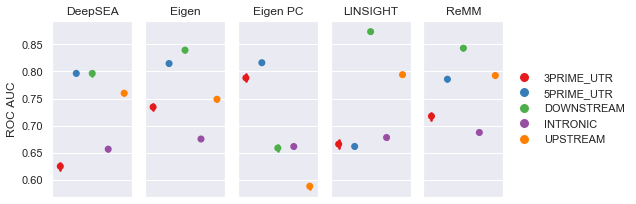

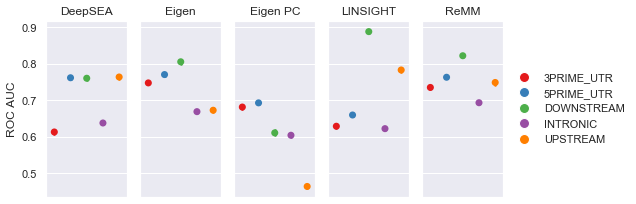

In [709]:
plot_roc_aucs(roc_auc_regions, groupby='Tool', classes='Category', title='ROC AUC tools genomic regions tools all variants', figsize=(9,3), colors=sns.color_palette('Set1'))
plot_roc_aucs(roc_auc_regions_hc, groupby='Tool', classes='Category', title='ROC AUC tools genomic regions tools HC variants', figsize=(9,3), colors=sns.color_palette('Set1'))

Comments:
<ul>
    <li>All tools except Eigen PC perform best in downstream regions</li>
    <li>All tools perform well in 5'utr regions, except Linsight, which performs worst in 5'utr.</li>
    <li>All tools perform relatively bad in 3'utr except for Eigen PC.</li>
    <li>All tools perform bad for intronic regions</li>
    <li>All tools perform well for upstream except for Eigen PC.
</ul>


ROC AUC genomic regions tools all variants
ROC AUC genomic regions tools HC variants


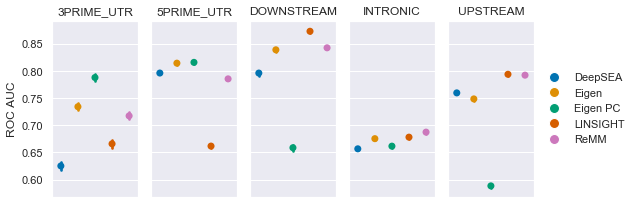

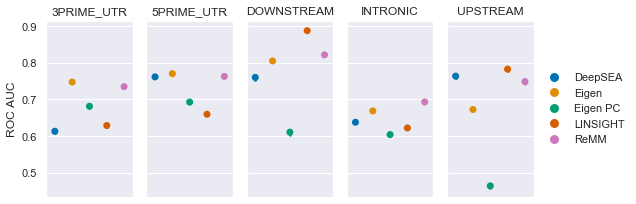

In [710]:
plot_roc_aucs(roc_auc_regions, groupby='Category', classes='Tool', title='ROC AUC genomic regions tools all variants', figsize=(9,3), colors=sns.color_palette('colorblind'))
plot_roc_aucs(roc_auc_regions_hc, groupby='Category', classes='Tool', title='ROC AUC genomic regions tools HC variants', figsize=(9,3), colors=sns.color_palette('colorblind'))

Comments:
For these pathogenic variants:
<ul>
    <li>No big differences in AUC between all variants and high-confidence variants.</li>
    <li>Linsight and ReMM perform best in downstream regions.</li>
    <li>Eigen PC performs worst in upstream, intronic and downstream.</li>
    <li>ReMM, DeepSEA and Eigen perform quite consistent.</li>
</ul>

<h3>Allele frequency bins</h3>

In [713]:
balanced_af = return_balanced_data(data_filtered, column='bins', random_state=53)
print('All variants')
counts_af(balanced_af[balanced_af.label == 'Pathogenic'], balanced_af[balanced_af.label == 'Benign'])

All variants


,Pathogenic,Benign
0.0 - 1e-06,186,186
0.0001 - 0.001,61,61
1e-05 - 0.0001,47,47
0.001 - 0.01,23,23
1e-06 - 1e-05,14,14
0.01 - 1.0,9,9


In [714]:
balanced_af_hc = return_balanced_data(data_filtered_hc, column='bins', random_state=53)
print('High-confidence variants')
counts_af(balanced_af_hc[balanced_af_hc.label == 'Pathogenic'], balanced_af_hc[balanced_af_hc.label == 'Benign'])


High-confidence variants


,Pathogenic,Benign
0.0 - 1e-06,59,59
0.0001 - 0.001,34,34
1e-05 - 0.0001,21,21
0.001 - 0.01,18,18
1e-06 - 1e-05,7,7
0.01 - 1.0,5,5


In [715]:
roc_auc_af = compute_roc_auc_values_per_tool_and_category(
    data_filtered.dropna(subset=['bins']),
    cols=tools, 
    categories='bins')

0.0 - 1e-06       186
0.0001 - 0.001     61
1e-05 - 0.0001     47
0.001 - 0.01       23
1e-06 - 1e-05      14
0.01 - 1.0          9
Name: bins, dtype: int64


In [716]:
roc_auc_af_hc = compute_roc_auc_values_per_tool_and_category(
    data_filtered_hc.dropna(subset=['bins']),
    cols=tools, 
    categories='bins')

0.0 - 1e-06       66
0.0001 - 0.001    34
1e-05 - 0.0001    21
0.001 - 0.01      18
1e-06 - 1e-05      7
0.01 - 1.0         5
Name: bins, dtype: int64


ROC AUC tools AF bins tools all variants
ROC AUC tools AF bins tools HC variants


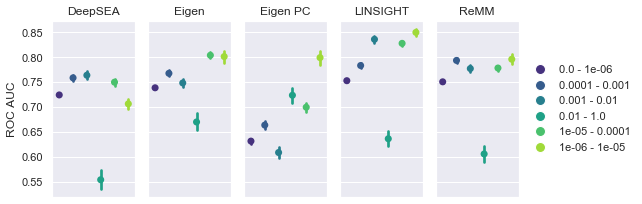

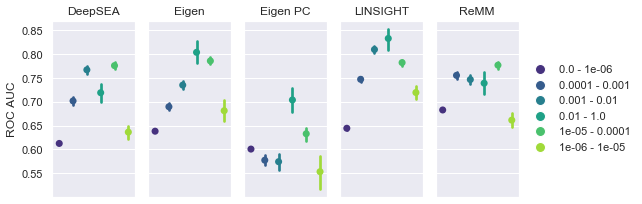

In [717]:
plot_roc_aucs(roc_auc_af, groupby='Tool', classes='Category', title='ROC AUC tools AF bins tools all variants', figsize=(9,3), colors=sns.color_palette('viridis'))
plot_roc_aucs(roc_auc_af_hc, groupby='Tool', classes='Category', title='ROC AUC tools AF bins tools HC variants', figsize=(9,3), colors=sns.color_palette('viridis'))


ROC AUC AF bins tools all variants
ROC AUC AF bins tools HC variants


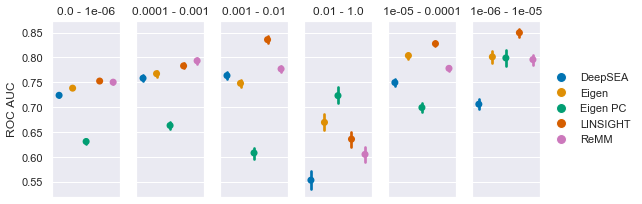

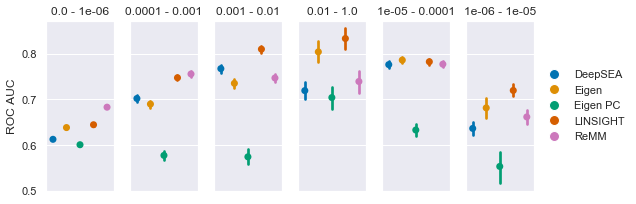

In [718]:
plot_roc_aucs(roc_auc_af, groupby='Category', classes='Tool', title='ROC AUC AF bins tools all variants', figsize=(9,3), colors=sns.color_palette('colorblind'), nplots=6)
plot_roc_aucs(roc_auc_af_hc, groupby='Category', classes='Tool', title='ROC AUC AF bins tools HC variants', figsize=(9,3), colors=sns.color_palette('colorblind'), nplots=6)


<h1>Predictor score correlation</h1>

In [1792]:
#correlations_matrix = nc[numerical_features].corr()
#clustermap(correlations_matrix, figsize=(13,8))
correlation_matrix = data_filtered[tools].corr()
correlation_matrix

,ReMM_score,DeepSEA_Functional_significance_score,Eigen_raw,Eigen PC_raw,LINSIGHT_score
ReMM_score,1.000000,0.560640,0.658088,0.284128,0.469604
DeepSEA_Functional_significance_score,0.560640,1.000000,0.582303,0.163514,0.363361
Eigen_raw,0.658088,0.582303,1.000000,0.606206,0.663762
Eigen PC_raw,0.284128,0.163514,0.606206,1.000000,0.167817
LINSIGHT_score,0.469604,0.363361,0.663762,0.167817,1.000000


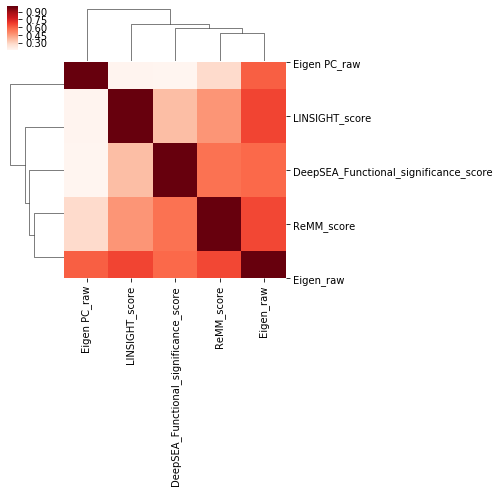

In [1793]:
clustermap(correlation_matrix, figsize=(5,5), cmap="Reds")

<ul>
    <li>Linsight and Eigen are correlated (0.6). Did they use the same features for training?</li>
    <li>Eigen PC is only correlated with Eigen, not with the other tools.</li>
</ul>

In [ ]:
correlation_matrix = data_filtered[tools].corr()
correlation_matrix

In [611]:
def compute_roc_auc_values_per_tool(df, cols, categories, title):
    #Returns a dict that looks like
    #{category1: {tool1: [auc values], tool2: [auc values]}, category2: {....}}
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()
    plt.suptitle(title, fontsize=24, y=1.08)
    
    print(df[df.label == 'Pathogenic'][categories].value_counts())
    
    all_auc_values = {}
    for n, category in enumerate(list(set(df[categories]))):
        auc_values = {}
        for i in range(100):
            df_f = df[df[categories] == category]
            g = df_f.groupby('label', group_keys=False)
            balanced = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(), random_state=i)))
            for tool in cols:
                if tool not in auc_values:
                    auc_values[tool] = []
                fpr, tpr, t = roc_curve(balanced.binarized_label, balanced[tool], pos_label=1)
                auc_values[tool].append(round(auc(fpr, tpr), 3))
        
        for tool in cols:
            axes[n].plot(range(len(auc_values[tool])), auc_values[tool], label=tool)
        
        all_auc_values[category] = auc_values
          
        if n == 3:
            axes[n].legend(labels=[tool.split('_')[0] for tool in tools],  bbox_to_anchor=(1.4, 1), loc='upper right')
        axes[n].set_title(category)
        axes[n].set(xlabel='ROC AUC')
        axes[n].set(xlabel='Random state')
        axes[n].set_ylim([0.3, 1])
    
    fig.subplots_adjust(right=0.9)
    fig.delaxes(axes[5])
    plt.tight_layout()
    
    return all_auc_values

def convert_roc_auc_dict(d):
    #Converts the dict from compute_roc_auc_values_per_tool() to:
    #{tool1: {category1: [auc values], category2: [auc values]}, tool2: {....}}
    d_converted = {}
    for category in d:
        for tool in d[category]:
            if tool not in d_converted:
                d_converted[tool] = {}
            d_converted[tool][category] = d[category][tool] 
    return d_converted


def plot_avg_roc_auc(d, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    plt.suptitle(title, fontsize=16, y=1.05)
    axes = axes.flatten()
    for i, key1 in enumerate(d):
        avg_aucs = [np.average(d[key1][key2]) for key2 in d[key1]]
        titles = [re.sub(r'\[|\)', '', str(key2).split('_')[0]) for key2 in d[key1]]
        axes[i].barh(y=titles, width=avg_aucs)
        axes[i].set_title(re.sub(r'\[|\)', '', str(key1).split('_')[0]))

    plt.tight_layout()


def plot_roc_auc_values(d):
    #Input = dictionary
    sns.set()
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    axes = axes.flatten()
    plt.suptitle('', fontsize=24, y=1.08)

    for i, key1 in enumerate(d):
        values_to_plot = []
        values = []
        labels = []
        names = []
        for key2 in d[key1]:
#         for region in regions:
            aucs = d[key1][key2]
            m = np.mean(aucs)
            se = scipy.stats.sem(aucs)
            n = len(aucs)
            h = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
            values.append(m-h)
            values.append(m+h)
            labels.append(key2)
            labels.append(key2)
            names.append(key2)

        sns.pointplot(x=[l.split('_')[0] for l in labels], y=values, join=False, ax=axes[i], palette=sns.color_palette("Set1"), ci=95)
        axes[i].set_title(key1)
        axes[i].set_xticks([])
        
    plt.legend(names)
    plt.tight_layout()
    

INTRONIC      239
UPSTREAM      238
5PRIME_UTR    196
DOWNSTREAM    103
3PRIME_UTR     59
Name: Consequence, dtype: int64


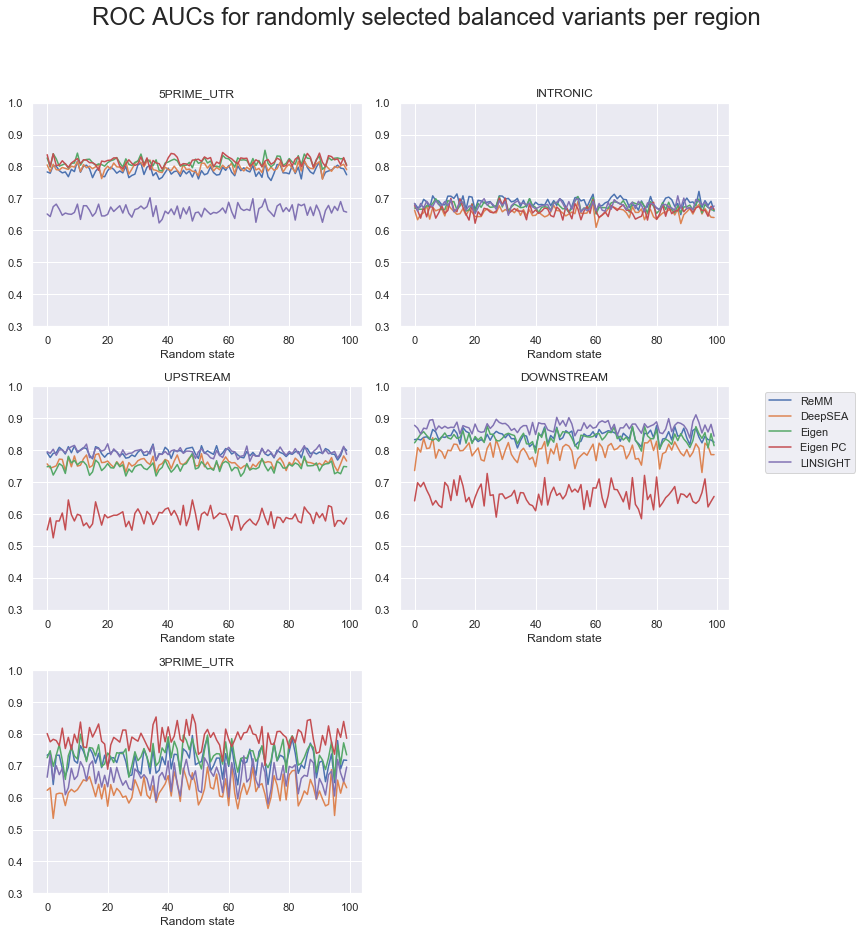

In [610]:
auc_values_regions = compute_roc_auc_values_per_tool(data_filtered[data_filtered.Consequence.isin(regions)], cols=tools, categories='Consequence', title='ROC AUCs for randomly selected balanced variants per region')

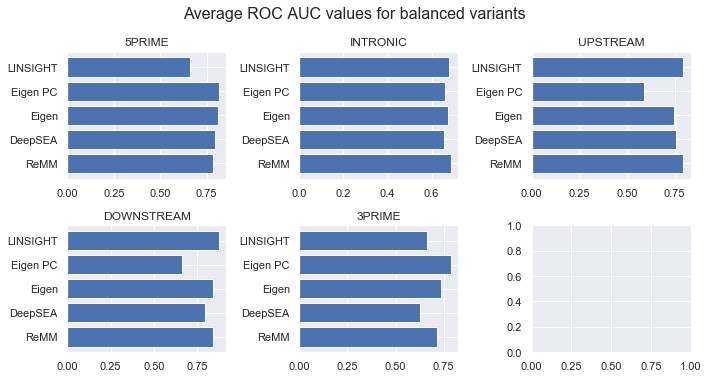

In [614]:
plot_avg_roc_auc(auc_values_regions, title='Average ROC AUC values for balanced variants')

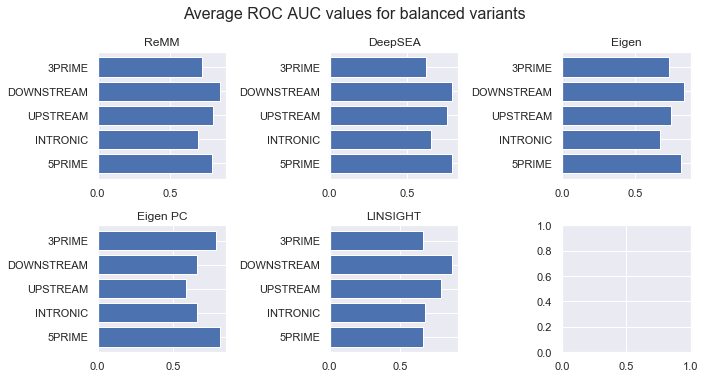

In [615]:
plot_avg_roc_auc(convert_roc_auc_dict(auc_values_regions), title='Average ROC AUC values for balanced variants')

In [ ]:
# def plot_scores_and_average_precision_per_category(df, col):
def plot_scores_and_wilcox_z_per_category(df, col, title):
    fig, axes = plt.subplots(5, 2, figsize=(12, 16))
    axes = axes.flatten()
    plt.suptitle(title, fontsize=24, y=1.05)
    for i in range(len(tools)):
        tool = tools[i]
        name = re.split(r'-|_', tool)[0]
        ax0 = axes[i*2]
        ax1 = axes[(i*2)+1]
        regions = list(set(df[col]))

        #Boxplots of scores
        sns.boxplot(
            x=tool,
            y=col,
            hue='label',
            data=df,
            palette='muted',
            showfliers=False,
            ax=ax0
        )
        ax0.set_title(name)
        ax0.set(xlabel=name + ' score')
        ax0.get_legend().remove()
        
#         wilcoxon_results = [
#             scipy.stats.ranksums(
#                 x=df[(df.label == 'Pathogenic') & (df['Consequence'] == region)][tool].tolist(),
#                 y=df[(df.label == 'Benign') & (df['Consequence'] == region)][tool].tolist()
#             )
#             for region in regions
#         ]
        
#         z_scores = [x[0] for x in wilcoxon_results]
#         p_values = [str("%.3g" % x[1]) for x in wilcoxon_results]
        
#         ax1.barh(y=p_values, width=z_scores)
#         ax1.yaxis.set_label_position("right")
#         ax1.yaxis.tick_right()
#         ax1.set(xlabel='Wilcoxon Z-score', ylabel='P-value')
#         ax1.set_title(name)
        
    plt.tight_layout()

<h3>Comparing different allele frequencies</h3>

In [ ]:
#violinplots/boxplots of the score 